<a href="https://colab.research.google.com/github/gpullela/Nano-ML/blob/main/LeNet5_MNIST_Classification_Gourav_Pullela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## !pip3 install torch==1.13.0+cu116 torchvision==0.14.0+cu116 -f https://download.pytorch.org/whl/torch_stable.html
## used colab's latest versions of torch and torchvision

In [ ]:
import torch
import torch.nn as nn
## import torch.nn.functional as F # use iff using an older version than torch==2.0.1
import torchvision
import torchvision.transforms as transforms

In [ ]:
## checking pytorch version
print(torch.__version__)

2.0.1+cu118


In [ ]:
BATCH_SIZE = 32

## transformations with rescaling to resize 28x28 images to 32x32 for
## both train and test using mean and std for each dataset respectively
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

transform_test = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.1325,), std=(0.3105,))])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

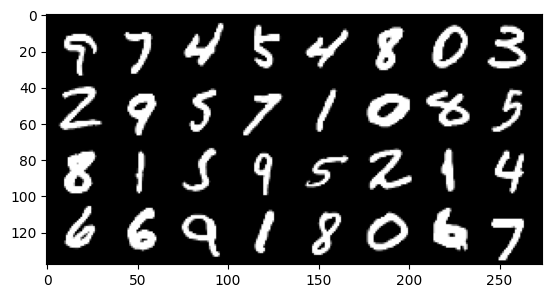

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
## Checking dimensions of a single batch after rescaling
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 32, 32])
Image label dimensions: torch.Size([32])


In [ ]:
## Defining LeNet5 class using nn.Module structure
class LeNet5(nn.Module):
    ## defining constructor with layers for LeNet5 transformations
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh())
        self.linear1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(120, 84),
            nn.Tanh())
        self.linear2 = nn.Sequential(
            nn.Linear(84,10),
            nn.Softmax(dim=-1))

    ## implement forward to perform transformations with different layers for LeNet5
    def forward(self, x):
        ## 32x1x32x32 ==(CONV2D)=> 32x6x28x28 ==(AVGPOOL2D)=> 32x6x14x14
        first = self.conv1(x) # first convolution layer and avg pooling with tanh as activation function
        ## 32x6x14x14 ==(CONV2D)=> 32x16x10x10 ==(AVGPOOL2D)=> 32x16x5x5
        second = self.conv2(first) # second convolution layer and avg pooling with tanh as activation function
        ## 32x16x5x5 ==(CONV2D)=> 32x120
        third = self.conv3(second) # third backwards convolution layer with tanh as activation function
        ## 32x120 ==(LINEAR)=> 32x84
        fourth = self.linear1(third) # Linear layer to flatten inputs and assimilate them with tanh as an activation function
        ## 32x84 ==(LINEAR)=> 32x10
        fifth = self.linear2(fourth) # Linear layer to reduce input size with softmax as final activation function
        return fifth

In [ ]:
## Defining LeNet5 class using nn.Module structure
class LeNetAlt(nn.Module):
    ## defining constructor with layers for LeNetAlt transformations
    def __init__(self):
        super(LeNetAlt, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=5, stride=5))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU())
        self.linear1 = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(120, 10),
            nn.ReLU(),
            nn.Softmax(dim=-1))

    ## implement forward to perform transformations with different layers for LeNet5
    def forward(self, x):

        ## 32x1x32x32 ==(CONV2D)=> 32x6x28x28 ==(AVGPOOL2D)=> 32x6x14x14
        first = self.conv1(x) # first convolution layer and avg pooling with tanh as activation function

        ## 32x6x14x14 ==(CONV2D)=> 32x16x10x10 ==(AVGPOOL2D)=> 32x16x5x5
        second = self.conv2(first) # second convolution layer and avg pooling with tanh as activation function

        ## 32x16x5x5 ==(CONV2D)=> 32x120
        third = self.linear1(second) # third backwards convolution layer with tanh as activation function

        return third

In [ ]:
## test the model with 1 batch
model = LeNet5()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 32, 32])
torch.Size([32, 10])


In [ ]:
## setting hyperparameters
learning_rate = 0.0001 # LR = 1e-4
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet5()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
## compute accuracy function
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
## declaring numpy arrays to store values to plot loss and accuracy across epochs
epochs = np.empty(10)
losses = np.empty(10)
accs = np.empty(10)
j=0

In [ ]:
## training model using num_epochs Epochs and BATCH_SIZE images per batch
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))
    epochs[j] = epoch
    losses[j] = train_running_loss / i
    accs[j] = train_acc / i
    j = j + 1

Epoch: 0 | Loss: 1.7080 | Train Accuracy: 83.07
Epoch: 1 | Loss: 1.5499 | Train Accuracy: 92.83
Epoch: 2 | Loss: 1.5240 | Train Accuracy: 94.75
Epoch: 3 | Loss: 1.5082 | Train Accuracy: 96.19
Epoch: 4 | Loss: 1.4983 | Train Accuracy: 96.99
Epoch: 5 | Loss: 1.4921 | Train Accuracy: 97.55
Epoch: 6 | Loss: 1.4879 | Train Accuracy: 97.88
Epoch: 7 | Loss: 1.4848 | Train Accuracy: 98.11
Epoch: 8 | Loss: 1.4825 | Train Accuracy: 98.37
Epoch: 9 | Loss: 1.4803 | Train Accuracy: 98.53


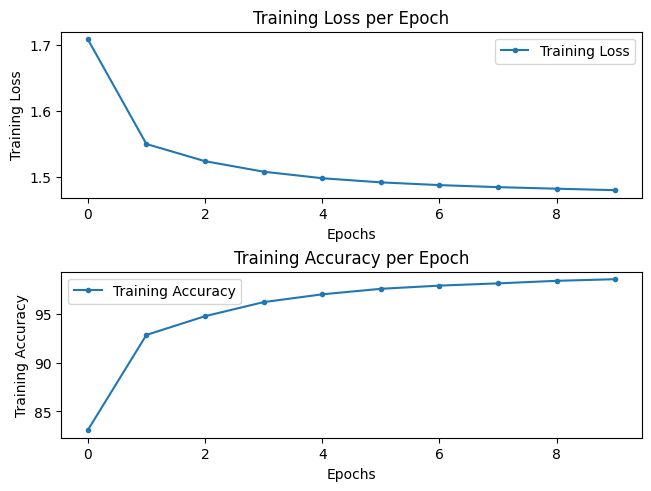

In [ ]:
## Plotting Training Loss and Accuracy across Epochs
plt.rcParams['figure.constrained_layout.use'] = True

## Epochs vs Training Loss Plot
plt.subplot(211)
plt.plot(epochs, losses, label='Training Loss', marker='.')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()

## Epochs vs Training Accuracy Plot
plt.subplot(212)
plt.plot(epochs, accs, label='Training Accuracy', marker='.')
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

In [ ]:
## testing data and calculating test accuracy
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.33
